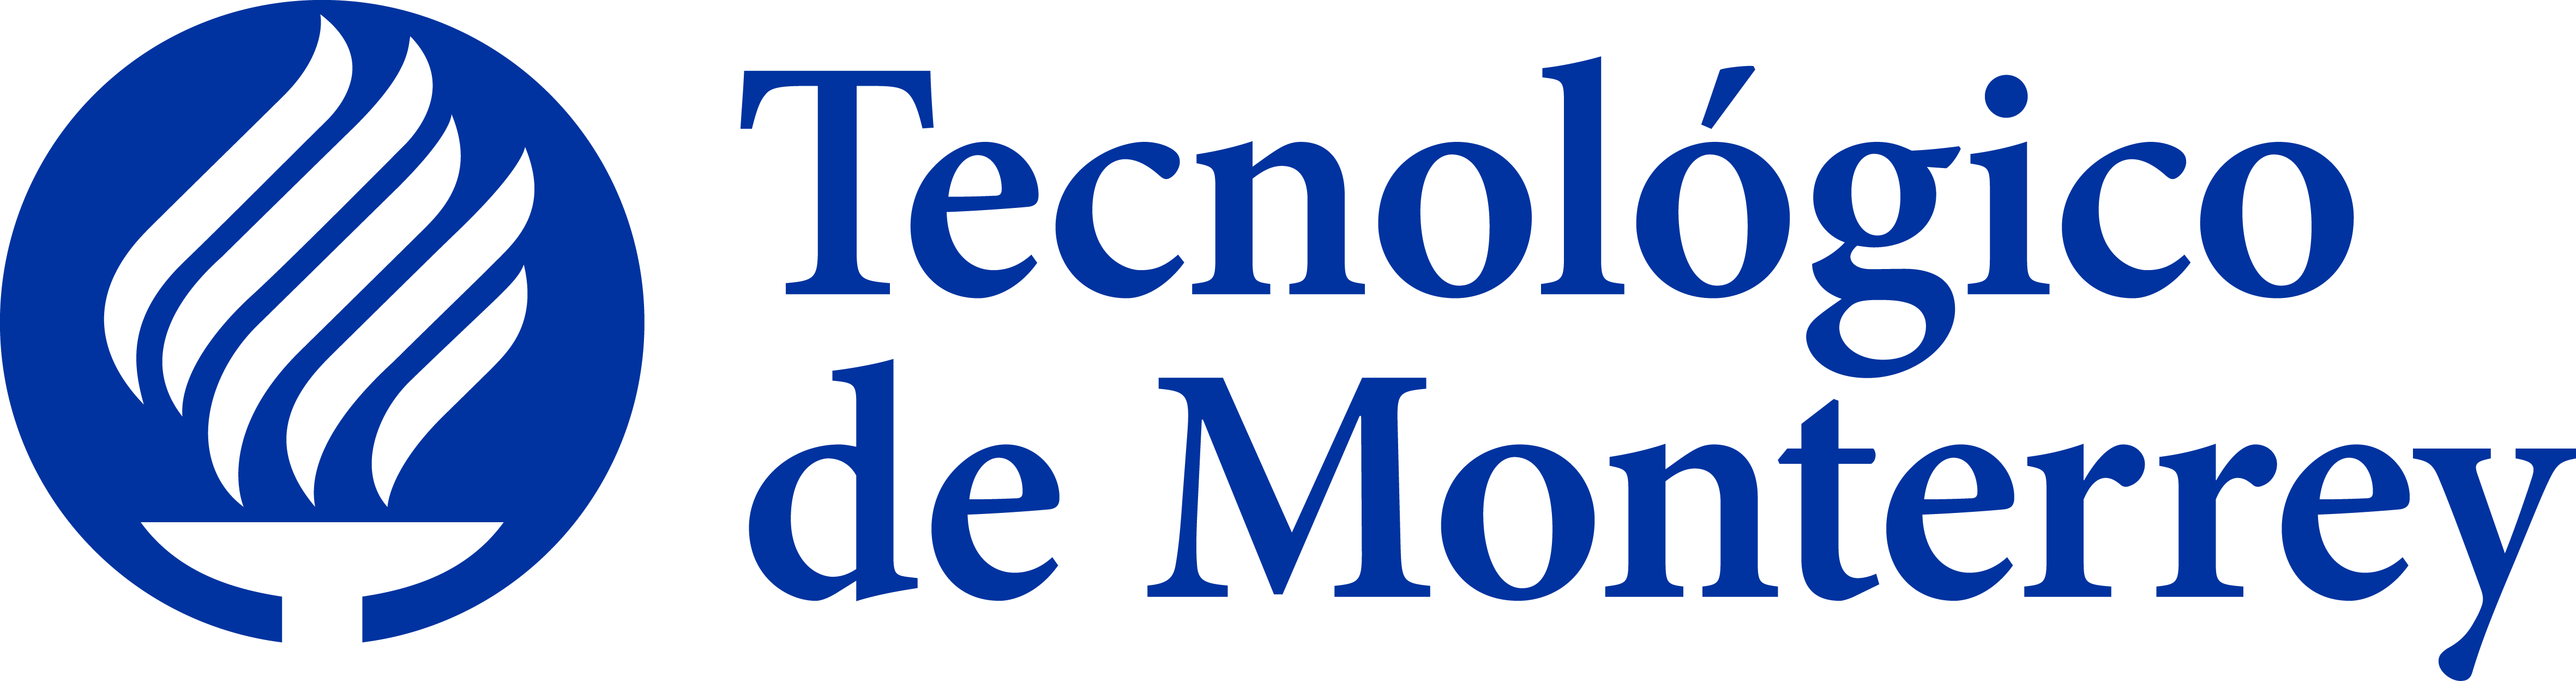

#***Generación de registros sintéticos de velocidad de la onda P***

Cecilia Acevedo Rodríguez
A01793953

# Entregable 1
# Estructura de los datos

##Descripción General de los datos

Los registros geofísicos de pozo (también conocidos como "well logging" en inglés) son mediciones de las propiedades físicas y químicas de las formaciones geológicas a lo largo de un pozo perforado. Estas mediciones se obtienen mediante la introducción de sondas instrumentadas en el pozo, que registran diversos datos en función de la profundidad.

Los datos están almacenados en archivos ".LAS", el formato LAS fue desarrollado por la Canadian Well Logging Society (CWLS). Estos archivos están escritos en código ASCII estándar y por ello se conocen como archivos Log ASCII Standard.

El set de datos está compuesto por 204 archivos de formato LAS que corresponden a 204 pozos de un área determinada.

In [ ]:
pip install lasio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 590.3 kB/s eta 0:00:00


In [ ]:
import requests
import io
import lasio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def read_las_from_github(repo_url, file_path):
    # Construir la URL del archivo RAW
    raw_file_url = f"{repo_url.rstrip('/').replace('github.com', 'raw.githubusercontent.com')}/main/{file_path}"

    # Obtener el contenido del archivo
    response = requests.get(raw_file_url)
    if response.status_code == 200:
        # Crear un objeto StringIO a partir del contenido del archivo
        file_content = "\n".join(response.text.splitlines())
        file_obj = io.StringIO(file_content)

        # Leer el contenido del archivo LAS
        las_data = lasio.read(file_obj)

        # Convertir los datos LAS a un DataFrame
        las_df = las_data.df()
        return las_df
    else:
        print(f"Error al obtener el archivo LAS desde {raw_file_url}. Código de estado: {response.status_code}")
        return None

def get_files_in_folder(repo_url, folder_path):
    # Construir la URL de la API para obtener el contenido del directorio
    api_url = f"{repo_url.rstrip('/').replace('github.com', 'api.github.com/repos')}/contents/{folder_path}"

    # Realizar la solicitud GET a la API de GitHub
    response = requests.get(api_url)

    if response.status_code == 200:
        # Parsear la respuesta JSON
        data = response.json()

        # Extraer los nombres de los archivos
        file_names = [item['name'] for item in data if item['type'] == 'file']
        return file_names
    else:
        print(f"Error al obtener la lista de archivos del directorio {folder_path}. Código de estado: {response.status_code}")
        return None


def get_data_from_files(repo_url, folder_path):
    file_names = get_files_in_folder(repo_url, folder_path)
    if file_names:
        df = pd.DataFrame()  # DataFrame vacío para almacenar los datos
        for file_name in file_names:
            las_data = read_las_from_github(repo_url, f"{folder_path}/{file_name}")
            if las_data is not None:
                # Combinar datos en el DataFrame
                df = pd.concat([df, las_data], axis=0, ignore_index=True)
        return df
    else:
        return None

# Obtener datos de los archivos y combinar en un DataFrame
repo_url = "https://github.com/cacevedo29/Equipo47"
folder_path = "data"
df = get_data_from_files(repo_url, folder_path)

# Mostrar el DataFrame resultante
print(df)

         CAL  DRHO       DT       GR        ILD  LLD  LLS  MSFL  NPHI  PEF  \
0        NaN   NaN      NaN  21.2810   204.0882  NaN  NaN   NaN   NaN  NaN   
1        NaN   NaN      NaN  20.6261  1103.3665  NaN  NaN   NaN   NaN  NaN   
2        NaN   NaN      NaN  19.9730  2000.0000  NaN  NaN   NaN   NaN  NaN   
3        NaN   NaN      NaN  20.5583  2000.0000  NaN  NaN   NaN   NaN  NaN   
4        NaN   NaN      NaN  21.1400  2000.0000  NaN  NaN   NaN   NaN  NaN   
...      ...   ...      ...      ...        ...  ...  ...   ...   ...  ...   
2936994  NaN   NaN  48.6283      NaN        NaN  NaN  NaN   NaN   NaN  NaN   
2936995  NaN   NaN  48.6318      NaN        NaN  NaN  NaN   NaN   NaN  NaN   
2936996  NaN   NaN  48.6353      NaN        NaN  NaN  NaN   NaN   NaN  NaN   
2936997  NaN   NaN  48.6388      NaN        NaN  NaN  NaN   NaN   NaN  NaN   
2936998  NaN   NaN  48.6423      NaN        NaN  NaN  NaN   NaN   NaN  NaN   

         ...  DTCO  CNL  CNL-ENTUB1  NORM  MINV  RG  DTS  SGFM 

Un pozo se perfora por etapas para asegurar el control de presiones, la estabilidad del pozo, la resolución de problemas operativos, la seguridad, y la adecuada evaluación de las formaciones geológicas, optimizando así el éxito y la eficiencia de la operación de perforación.

Al finalizar cada etapa, se introducen las sondas que miden los registros geofísicos. Sin embargo, no todas las etapas son iguales; es decir, no todas registran las mismas propiedades. Esta variabilidad también se observa entre los distintos pozos, ya que no se recopila la misma información en cada uno de ellos. Esta diferencia justifica la gran cantidad de valores nulos que se encuentran en el data frame.

## Análisis univariante

Este análisis sirve para hacer el control de calidad de la carga de los datos identificando si existe algun valor fuera del rango en cada registro.

In [ ]:
# Análisis univariante de cada columna del DataFrame
print(df.describe())


                CAL          DRHO            DT            GR           ILD  \
count  39317.000000  1.000148e+06  1.201853e+06  2.558755e+06  1.475955e+06   
mean       6.316222 -2.847235e+01  8.400004e+01  4.220339e+01  8.036239e+01   
std        6.141392  2.382719e+02  9.143841e+02  6.102206e+02  2.565835e+03   
min     -653.677400 -1.998500e+03 -1.000000e+06 -9.557048e+05 -7.493880e+02   
25%        0.000000  0.000000e+00  5.505900e+01  3.000640e+01  8.620000e-01   
50%        7.941500  1.570000e-02  7.208450e+01  4.071700e+01  1.105100e+00   
75%        9.816100  5.050000e-02  1.141634e+02  5.176060e+01  1.587000e+00   
max       21.999700  2.759517e+03  4.001000e+03  1.130848e+03  1.000000e+06   

                  LLD            LLS           MSFL          NPHI  \
count   881225.000000   858741.00000  740662.000000  1.264565e+06   
mean      1893.291490     1740.50422     245.074596 -1.021404e+02   
std       8223.332224    15386.93949    1616.114409  3.322260e+03   
min   -10000

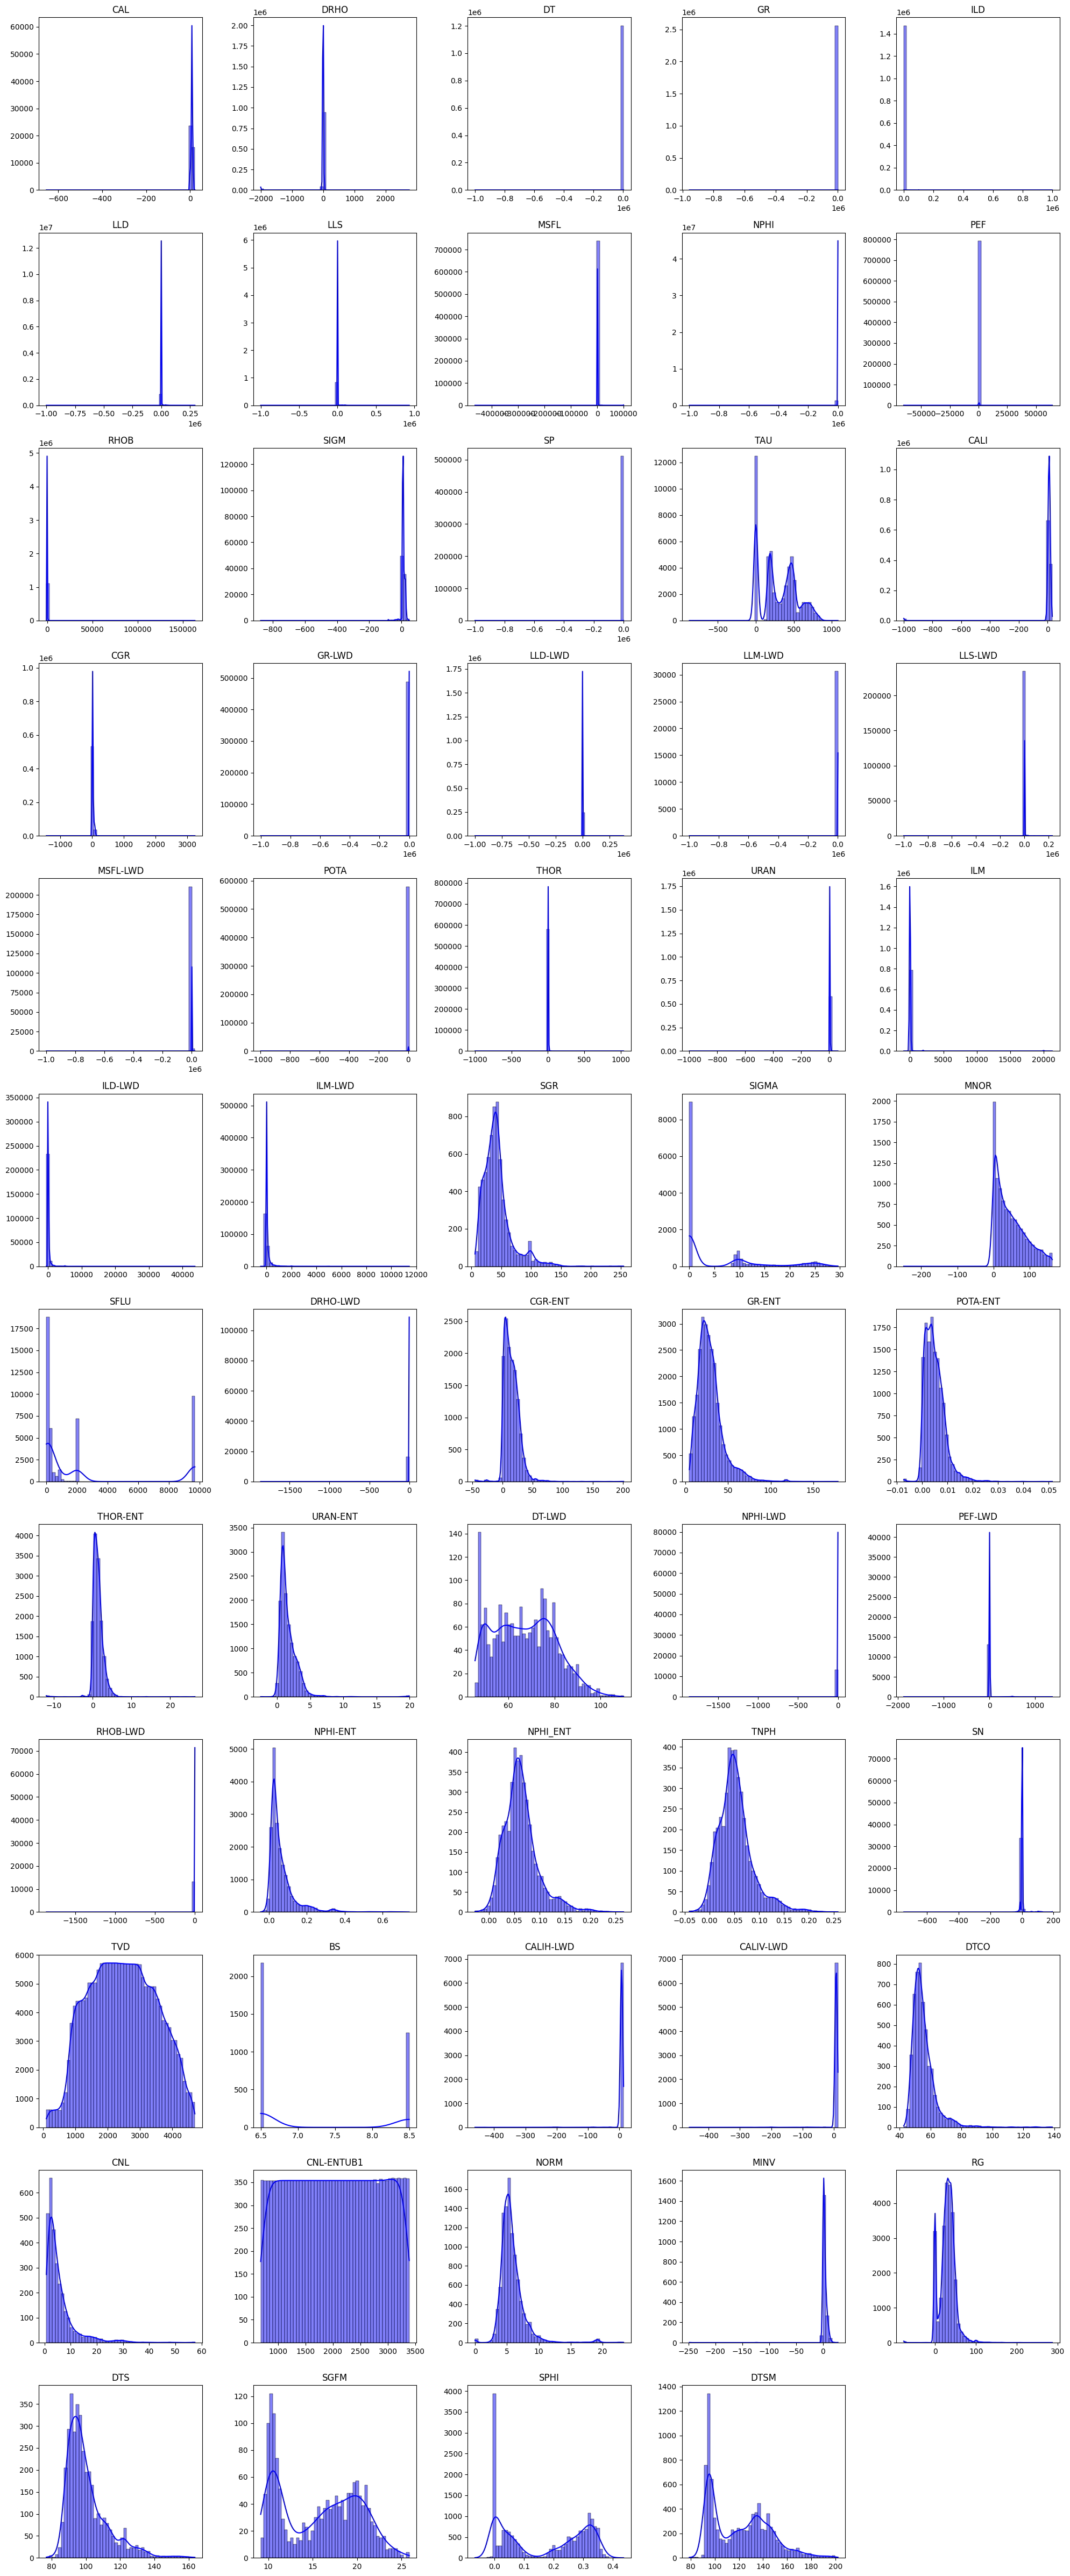

In [ ]:
import seaborn as sns

# Configuración de la gráfica
num_cols = 5
num_rows = int(len(df.columns) / num_cols) + 1

plt.figure(figsize=(20, num_rows * 4))

# Crear un histograma para cada columna del DataFrame
for i, column in enumerate(df.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df[column].dropna(), bins=50, kde=True, color='blue')
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

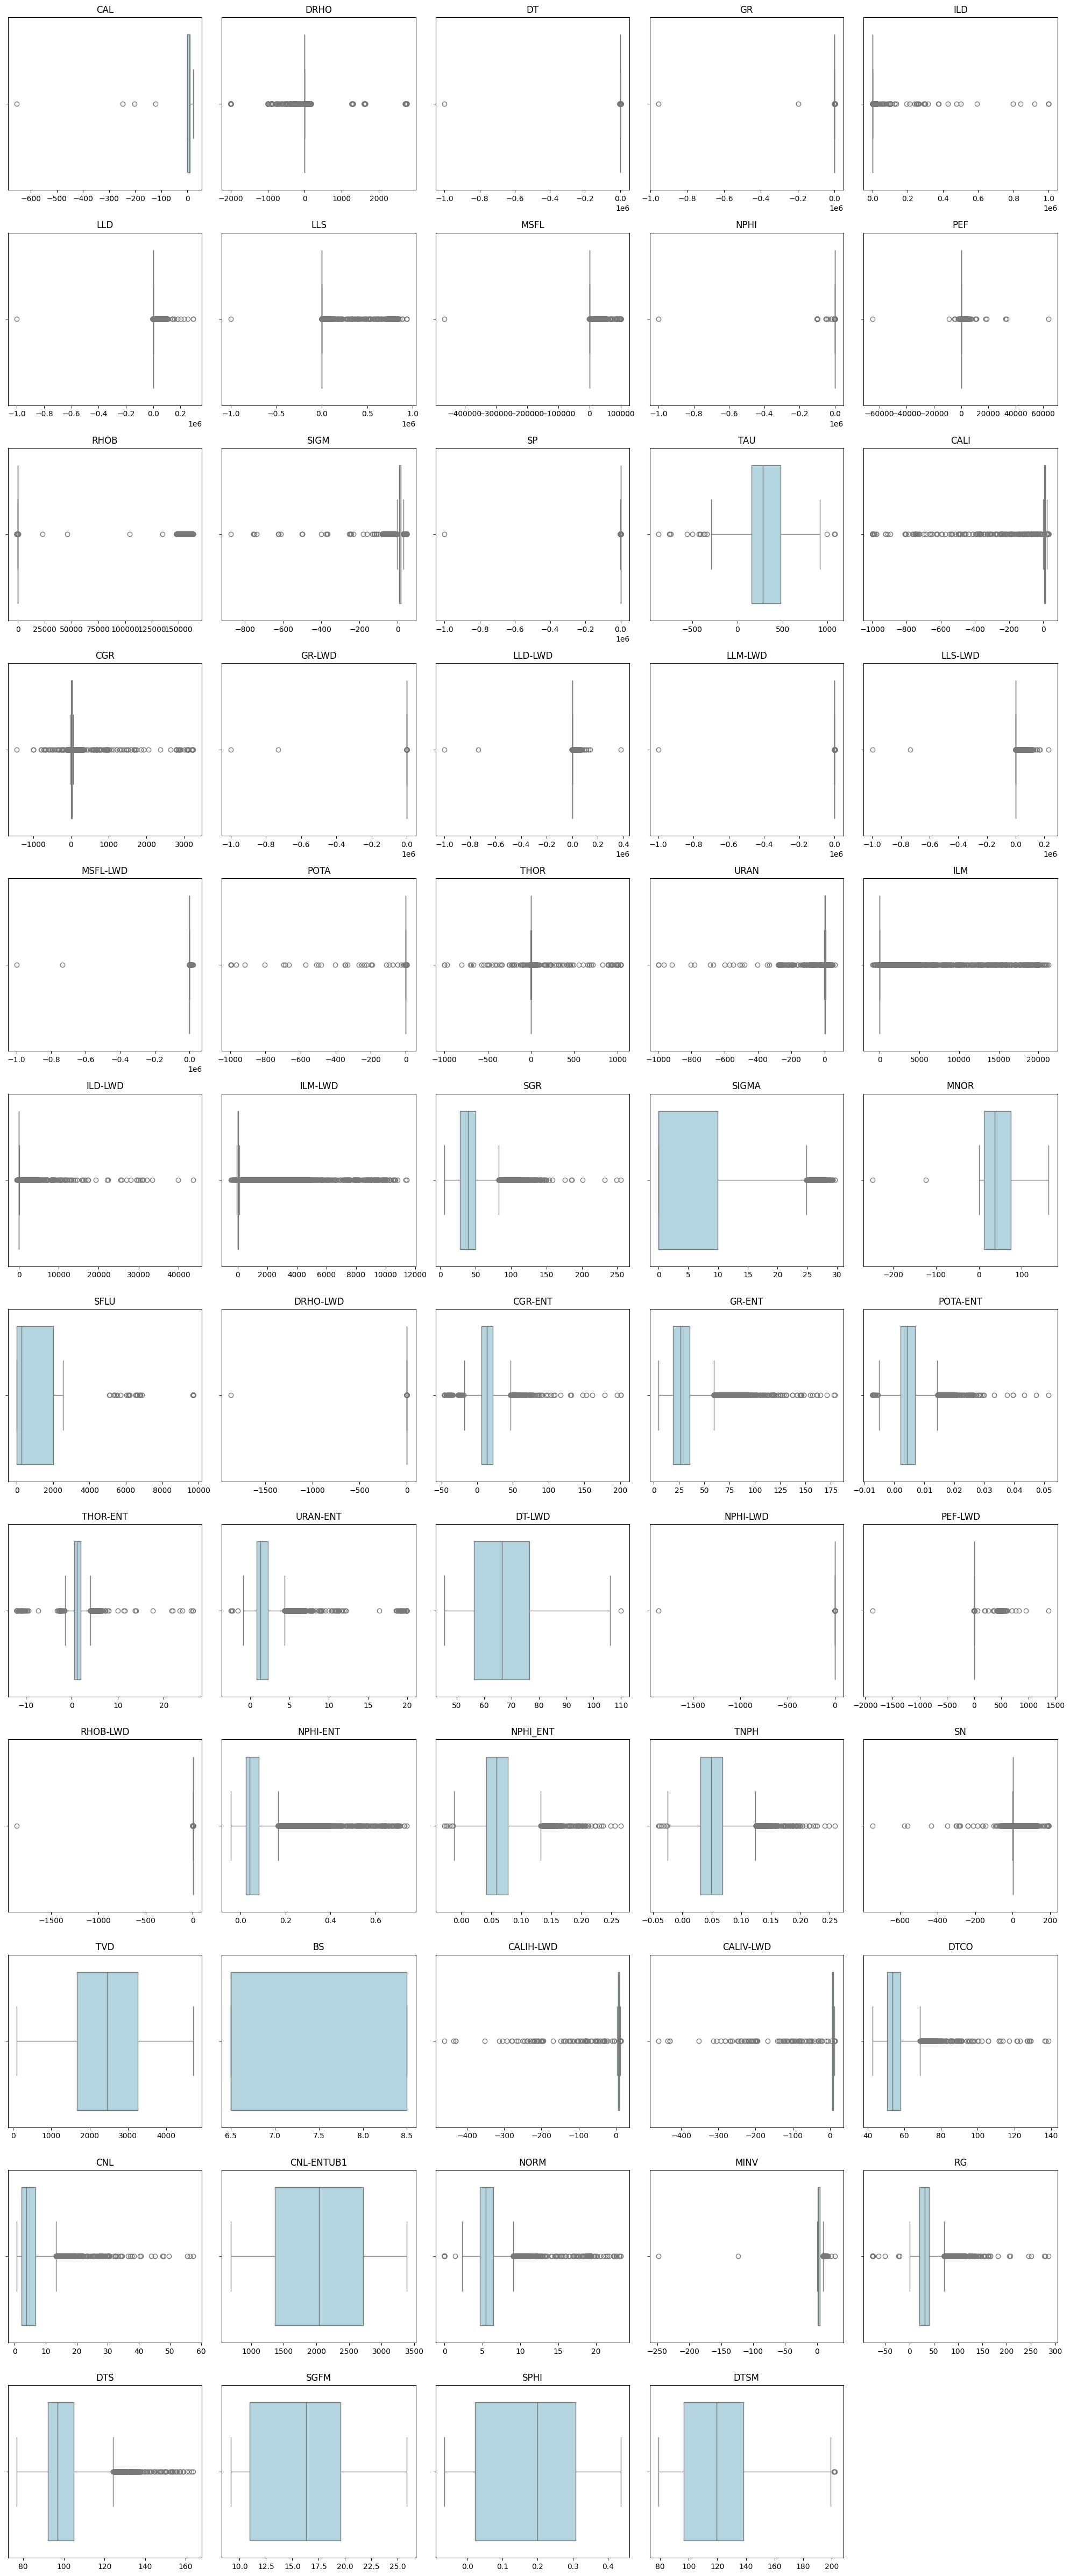

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de la gráfica
num_cols = 5
num_rows = int(len(df.columns) / num_cols) + 1

plt.figure(figsize=(20, num_rows * 4))

# Crear un boxplot para cada columna del DataFrame
for i, column in enumerate(df.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x=df[column], color='lightblue')
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


 ## Análisis multivariante




In [ ]:
# Análisis de correlaciones
correlation_matrix = df.corr()
print(correlation_matrix)


                 CAL      DRHO        DT        GR       ILD       LLD  \
CAL         1.000000 -0.654942  0.562849  0.395005 -0.009784  0.074542   
DRHO       -0.654942  1.000000 -0.003569 -0.012021 -0.012558  0.008695   
DT          0.562849 -0.003569  1.000000  0.001062 -0.090222 -0.016497   
GR          0.395005 -0.012021  0.001062  1.000000 -0.025882 -0.098265   
ILD        -0.009784 -0.012558 -0.090222 -0.025882  1.000000  0.005963   
LLD         0.074542  0.008695 -0.016497 -0.098265  0.005963  1.000000   
LLS         0.191058  0.008849  0.007281 -0.028181  0.001740  0.443955   
MSFL       -0.005613  0.012404 -0.010972 -0.036101  0.012876  0.149967   
NPHI        0.459208  0.000341  0.005123  0.009282  0.004827  0.002876   
PEF         0.111926  0.001758  0.000062 -0.013379 -0.007658 -0.003558   
RHOB        0.394187  0.001674  0.000523  0.001959  0.007569 -0.006208   
SIGM       -0.065291  0.008056  0.043959  0.164215  0.055014  0.038620   
SP          0.123121 -0.009090  0.0086

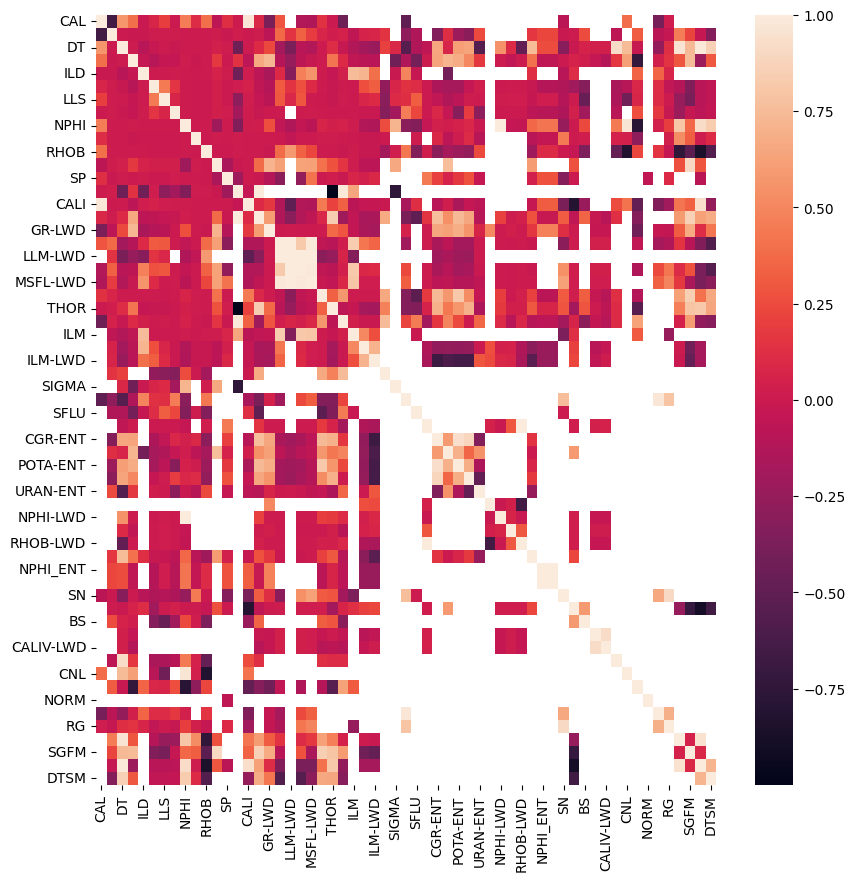

In [ ]:
correlation_df = pd.DataFrame(correlation_matrix)

# Create a figure with the desired figsize
plt.figure(figsize=(10, 10))

# Plot the heatmap on the figure
sns.heatmap(correlation_df, annot=False)
plt.show()

## Preprocesamiento

En esta sección limpiaremos el data set, como pudimos ver anteriormente tenemos un gran número de registros dentro de los archivos; sin embargo, para la creación del modelo solo necesitamos los registros cuyos valores están asociados a las propiedades de las rocas los cuales describo a continuación:

**Registros de Resistencia (Resistividad) [RT]**
Propósito: Determinan la capacidad de las formaciones para resistir el flujo de corriente eléctrica.
Aplicaciones: Identificación de hidrocarburos (que son resistivos en comparación con las formaciones acuíferas).

**Registros de Gamma Natural [GR]**
Propósito: Miden la radioactividad natural de las formaciones.
Aplicaciones: Identificación de lutitas y otros minerales radioactivos.

**Registros de Densidad [RHOB]**
Propósito: Miden la densidad de las formaciones.
Aplicaciones: Evaluación de la porosidad y estimación de la saturación de fluidos.

**Registros de Neutrón [NPHI]**
Propósito: Miden la concentración de hidrógeno en las formaciones.
Aplicaciones: Determinación de la porosidad y detección de hidrocarburos.

**Registros Sónicos [DT]**
Propósito: Miden la velocidad de las ondas sonoras a través de las formaciones.
Aplicaciones: Determinación de las propiedades elásticas de las rocas, correlación de formación y detección de fracturas.

In [ ]:
# Lista de registros a conservar
registros_a_conservar = ['ILD', 'RG', 'GR', 'SGR', 'TNPH', 'NPHI_ENT', 'NPHI', 'GR-ENT', 'RHOB', 'LLD', 'NPHI-ENT', 'DT', 'DTCO']

# Filtrar el DataFrame para conservar solo los registros especificados
df_filtrado = df[df.columns.intersection(registros_a_conservar)]

# Mostrar el DataFrame filtrado
print(df_filtrado)

new_df = df_filtrado


              DT       GR        ILD  LLD  NPHI  RHOB  SGR  GR-ENT  NPHI-ENT  \
0            NaN  21.2810   204.0882  NaN   NaN   NaN  NaN     NaN       NaN   
1            NaN  20.6261  1103.3665  NaN   NaN   NaN  NaN     NaN       NaN   
2            NaN  19.9730  2000.0000  NaN   NaN   NaN  NaN     NaN       NaN   
3            NaN  20.5583  2000.0000  NaN   NaN   NaN  NaN     NaN       NaN   
4            NaN  21.1400  2000.0000  NaN   NaN   NaN  NaN     NaN       NaN   
...          ...      ...        ...  ...   ...   ...  ...     ...       ...   
2936994  48.6283      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   
2936995  48.6318      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   
2936996  48.6353      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   
2936997  48.6388      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   
2936998  48.6423      NaN        NaN  NaN   NaN   NaN  NaN     NaN       NaN   

         NPHI_ENT  TNPH  DTCO  RG  
0  

In [ ]:
new_df

,DT,GR,ILD,LLD,NPHI,RHOB,SGR,GR-ENT,NPHI-ENT,NPHI_ENT,TNPH,DTCO,RG
0,NaN,21.2810,204.0882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,20.6261,1103.3665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,19.9730,2000.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,20.5583,2000.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,21.1400,2000.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936994,48.6283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936995,48.6318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936996,48.6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936997,48.6388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Conclusiones entregable 1

Hasta aquí ya tenemos solo las columnas que contienen los registros deseados; sin embargo, podemos observar que tenemos trece columnas cuando solo deberían ser cinco, lo que sucede es que un mismo registro puede llamarse diferente en algún archivo. Adicionalmente aún se observan valores nulos.


#Entregable 2

##Construcción

En esta sección combinaremos las columnas que corresponden a la misma propiedad.

In [ ]:
# Definir función para calcular la columna RT
def calcular_RT(fila):
    if not np.isnan(fila['ILD']) and np.isnan(fila['LLD']):
        return fila['ILD']
    elif np.isnan(fila['ILD']) and not np.isnan(fila['LLD']):
        return fila['LLD']
    elif np.isnan(fila['ILD']) and np.isnan(fila['LLD']):
        return np.nan
    else:
        return fila['ILD']

# Aplicar la función calcular_RT para crear la columna RT
new_df['RT'] = new_df.apply(calcular_RT, axis=1)

new_df = new_df.drop(columns=['ILD', 'LLD'])

# Mostrar las primeras filas del DataFrame para verificar que las columnas se han eliminado
new_df

<ipython-input-11-0411b2430946>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['RT'] = new_df.apply(calcular_RT, axis=1)


,DT,GR,NPHI,RHOB,SGR,GR-ENT,NPHI-ENT,NPHI_ENT,TNPH,DTCO,RG,RT
0,NaN,21.2810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0882
1,NaN,20.6261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1103.3665
2,NaN,19.9730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0000
3,NaN,20.5583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0000
4,NaN,21.1400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2936994,48.6283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936995,48.6318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936996,48.6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2936997,48.6388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
new_df2 = new_df

In [ ]:
# Creación de nuevas columnas combinadas
def combinar_valores_GR(row):
    if not np.isnan(row['GR']):
        return row['GR']
    elif not np.isnan(row['RG']):
        return row['RG']
    elif not np.isnan(row['SGR']):
        return row['SGR']
    elif not np.isnan(row['GR-ENT']):
        return row['GR-ENT']
    else:
        return np.nan

new_df2['Comb'] = new_df2.apply(combinar_valores_GR, axis=1)
new_df2 = new_df2.drop(columns=['RG', 'GR', 'SGR', 'GR-ENT'])

# Crear la nueva columna 'Comb_NPHI'
def combinar_valores_NPHI(row):
    if not np.isnan(row['TNPH']):
        return row['TNPH']
    elif not np.isnan(row['NPHI_ENT']):
        return row['NPHI_ENT']
    elif not np.isnan(row['NPHI']):
        return row['NPHI']
    elif not np.isnan(row['NPHI-ENT']):
        return row['NPHI-ENT']
    else:
        return np.nan

new_df2['Comb_NPHI'] = new_df2.apply(combinar_valores_NPHI, axis=1)
new_df2 = new_df2.drop(columns=['TNPH', 'NPHI_ENT', 'NPHI', 'NPHI-ENT'])

# Crear la nueva columna 'COMB_DT'
def combinar_valores_DT(row):
    if not np.isnan(row['DT']):
        return row['DT']
    elif not np.isnan(row['DTCO']):
        return row['DTCO']
    else:
        return np.nan

new_df2['COMB_DT'] = new_df2.apply(combinar_valores_DT, axis=1)


In [ ]:
new_df2

,DT,RHOB,DTCO,RT,Comb,Comb_NPHI,COMB_DT
0,NaN,NaN,NaN,204.0882,21.2810,NaN,NaN
1,NaN,NaN,NaN,1103.3665,20.6261,NaN,NaN
2,NaN,NaN,NaN,2000.0000,19.9730,NaN,NaN
3,NaN,NaN,NaN,2000.0000,20.5583,NaN,NaN
4,NaN,NaN,NaN,2000.0000,21.1400,NaN,NaN
...,...,...,...,...,...,...,...
2936994,48.6283,NaN,NaN,NaN,NaN,NaN,48.6283
2936995,48.6318,NaN,NaN,NaN,NaN,NaN,48.6318
2936996,48.6353,NaN,NaN,NaN,NaN,NaN,48.6353
2936997,48.6388,NaN,NaN,NaN,NaN,NaN,48.6388


In [ ]:
# Eliminar las columnas 'DT', 'DTCO'
new_df2 = new_df2.drop(columns=['DT', 'DTCO'])

# Mostrar las primeras filas del DataFrame para verificar que las columnas se han eliminado
new_df2

,RHOB,RT,Comb,Comb_NPHI,COMB_DT
0,NaN,204.0882,21.2810,NaN,NaN
1,NaN,1103.3665,20.6261,NaN,NaN
2,NaN,2000.0000,19.9730,NaN,NaN
3,NaN,2000.0000,20.5583,NaN,NaN
4,NaN,2000.0000,21.1400,NaN,NaN
...,...,...,...,...,...
2936994,NaN,NaN,NaN,NaN,48.6283
2936995,NaN,NaN,NaN,NaN,48.6318
2936996,NaN,NaN,NaN,NaN,48.6353
2936997,NaN,NaN,NaN,NaN,48.6388


In [ ]:
# Selección y extracción de características importantes
# Renombrar las columnas 'A' a 'X' y 'B' a 'Y'
df = new_df2.rename(columns={'Comb': 'GR', 'Comb_NPHI': 'NPHI', 'COMB_DT': 'DT' })

# Mostrar las primeras filas del DataFrame para verificar el cambio
df

,RHOB,RT,GR,NPHI,DT
0,NaN,204.0882,21.2810,NaN,NaN
1,NaN,1103.3665,20.6261,NaN,NaN
2,NaN,2000.0000,19.9730,NaN,NaN
3,NaN,2000.0000,20.5583,NaN,NaN
4,NaN,2000.0000,21.1400,NaN,NaN
...,...,...,...,...,...
2936994,NaN,NaN,NaN,NaN,48.6283
2936995,NaN,NaN,NaN,NaN,48.6318
2936996,NaN,NaN,NaN,NaN,48.6353
2936997,NaN,NaN,NaN,NaN,48.6388


Hasta este punto ya tenemos solo las cinco columnas de las propiedades requeridas, ya solo queda quitar los valores nulos.

In [ ]:
# Eliminar filas con al menos un valor NaN
df_clean = df.dropna(how='any')

print("\nDataFrame después de eliminar filas con al menos un valor NaN:")
df_clean


DataFrame después de eliminar filas con al menos un valor NaN:


,RHOB,RT,GR,NPHI,DT
12818,2.3150,0.4700,22.0720,0.2615,-219.3950
12819,2.2855,0.8544,24.0396,0.2993,-83.1787
12820,2.2560,1.2380,25.9970,0.3371,51.6810
12821,2.2670,5.2352,24.9453,0.3485,53.6462
12822,2.2780,9.2250,23.8990,0.3599,55.5920
...,...,...,...,...,...
2936919,2.5465,1503.6654,29.8856,0.0930,46.5962
2936920,2.5188,1503.3405,27.8816,0.0931,46.5724
2936921,2.5081,1503.0963,27.4429,0.0933,46.3989
2936922,2.5175,1502.9001,28.0458,0.0934,46.2970


In [ ]:
df_clean.describe()

,RHOB,RT,GR,NPHI,DT
count,759381.000000,759381.000000,759381.000000,759381.000000,759381.000000
mean,112.328611,1639.417492,43.245260,1.328593,73.531947
std,4137.888968,7775.517033,26.435016,61.392231,71.020865
min,-897.603000,-1000000.000000,-2240.000000,-49206.472700,-1598.500000
25%,2.409500,1.941300,26.550500,0.056000,52.223500
50%,2.623300,60.137000,38.279000,0.114000,60.300000
75%,2.727000,389.530000,52.447700,0.307900,81.518000
max,163339.921900,476261.437500,743.470100,74.007600,4001.000000


## Normalización

En esta parte no es necesario normalizar los datos aún, ya que la normalizacion se hará una vez que el set de datos este completamente construido.

## Selección-Extracción

En esta sección se filtrarán los datos, ya que como se observa en la descripción anterior hay valores que se salen del rango de las mediciones que deben tener las rocas. Se realizará el filtrado usando valores de corte para cada uno de los registros.

In [ ]:
# Definir las condiciones de filtrado para cada columna
condition_RT = (df_clean['RT'] >= 0.2) & (df_clean['RT'] <= 10000)
condition_GR = (df_clean['GR'] >= 0) & (df_clean['GR'] <= 150)
condition_NPHI = (df_clean['NPHI'] >= -0.15) & (df_clean['NPHI'] <= 0.45)
condition_DT = (df_clean['DT'] >= 40) & (df_clean['DT'] <= 140)
condition_RHOB = (df_clean['RHOB'] >= 1.5) & (df_clean['RHOB'] <= 3)

# Aplicar todas las condiciones de filtrado simultáneamente
geo_regist = df_clean[condition_RT & condition_GR & condition_NPHI & condition_DT & condition_RHOB]

print("\nDataFrame después de filtrar:")
geo_regist


DataFrame después de filtrar:


,RHOB,RT,GR,NPHI,DT
12820,2.2560,1.2380,25.9970,0.3371,51.6810
12821,2.2670,5.2352,24.9453,0.3485,53.6462
12822,2.2780,9.2250,23.8990,0.3599,55.5920
12823,2.2875,8.2637,24.3379,0.3475,55.6528
12824,2.2970,7.3040,24.7740,0.3352,55.7130
...,...,...,...,...,...
2936919,2.5465,1503.6654,29.8856,0.0930,46.5962
2936920,2.5188,1503.3405,27.8816,0.0931,46.5724
2936921,2.5081,1503.0963,27.4429,0.0933,46.3989
2936922,2.5175,1502.9001,28.0458,0.0934,46.2970


In [ ]:
geo_regist

,RHOB,RT,GR,NPHI,DT
12820,2.2560,1.2380,25.9970,0.3371,51.6810
12821,2.2670,5.2352,24.9453,0.3485,53.6462
12822,2.2780,9.2250,23.8990,0.3599,55.5920
12823,2.2875,8.2637,24.3379,0.3475,55.6528
12824,2.2970,7.3040,24.7740,0.3352,55.7130
...,...,...,...,...,...
2936919,2.5465,1503.6654,29.8856,0.0930,46.5962
2936920,2.5188,1503.3405,27.8816,0.0931,46.5724
2936921,2.5081,1503.0963,27.4429,0.0933,46.3989
2936922,2.5175,1502.9001,28.0458,0.0934,46.2970


In [ ]:
# Guardar el DataFrame como un archivo CSV en el entorno de ejecución local
geo_regist.to_csv('geo_regist.csv', index=False)


## Conclusiones Entregable 2

Se logró obtener un buen set de datos después de todos los procesos de limpieza y filtrado aplicados, el número de registros es adecuado para la generación de un modelo.

#Entregable 3

Para el problema que estamos atendiendo es importante considerar modelos que sean robustos y efectivos para problemas de regresión en datasets grandes. A continuación algunos modelos que se pueden implementar:

**Random Forest Regressor**. Es un modelo de ensamble basado en múltiples árboles de decisión. Tiene la ventaja de manejar bien datasets grandes, es robusto a outliers y no linealidades, y generalmente no requiere mucho ajuste de hiperparámetros.

**Gradient Boosting Regressor**. Modelo de ensamble que construye árboles de decisión secuencialmente para corregir errores de los árboles anteriores. Es efectivo para datos con relaciones no lineales y proporciona buenos resultados con ajuste adecuado.

**XGBoost**. Es un modelo de ensamble basado en boosting que es extremadamente eficiente y rápido. Tiene alto rendimiento, capacidad de manejar grandes datasets, y soporta paralelización.

**LightGBM**. Otro modelo de boosting que es eficiente y rápido, especialmente para datasets grandes. Entre sus ventajas está la alta velocidad y eficiencia, manejo de grandes datasets.

**CatBoost**. Otro modelo de boosting que maneja bien características categóricas y numéricas. Presenta alta precisión, fácil de usar, no requiere mucho preprocesamiento.

Modelos más simples como Linear Regression y SVR pueden no ser tan efectivos y pueden ser descartados para este propósito específico.

In [2]:
!pip install xgboost lightgbm catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
geo_regist = pd.read_csv('geo_regist.csv', encoding='utf-8')

## Partición de Datos

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar las características y la variable objetivo
X = geo_regist.drop('DT', axis=1)
y = geo_regist['DT']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Entrenar Modelos

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Definir una lista de modelos que deseas probar
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(silent=True)
}

results = {}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    print(f"Entrenando y evaluando modelo: {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MSE': mse, 'R2': r2}

    print(f"Modelo: {name}")
    print(f"Error Cuadrático Medio (MSE): {mse}")
    print(f"Coeficiente de Determinación (R^2): {r2}")
    print("-" * 30)

# Mostrar los resultados
results_df = pd.DataFrame(results).T
print(results_df)


Entrenando y evaluando modelo: Random Forest
Modelo: Random Forest
Error Cuadrático Medio (MSE): 110.096748912958
Coeficiente de Determinación (R^2): 0.7981797284886519
------------------------------
Entrenando y evaluando modelo: Gradient Boosting
Modelo: Gradient Boosting
Error Cuadrático Medio (MSE): 137.4391299348553
Coeficiente de Determinación (R^2): 0.7480579327399987
------------------------------
Entrenando y evaluando modelo: XGBoost
Modelo: XGBoost
Error Cuadrático Medio (MSE): 121.26208363933691
Coeficiente de Determinación (R^2): 0.7777123585777166
------------------------------
Entrenando y evaluando modelo: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 453621, number of used features: 4
[LightGBM] [Info] Start training from score 68.823247
Modelo: LightGBM
E

<ipython-input-8-b8c569f05e1e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=results_df, palette="viridis")


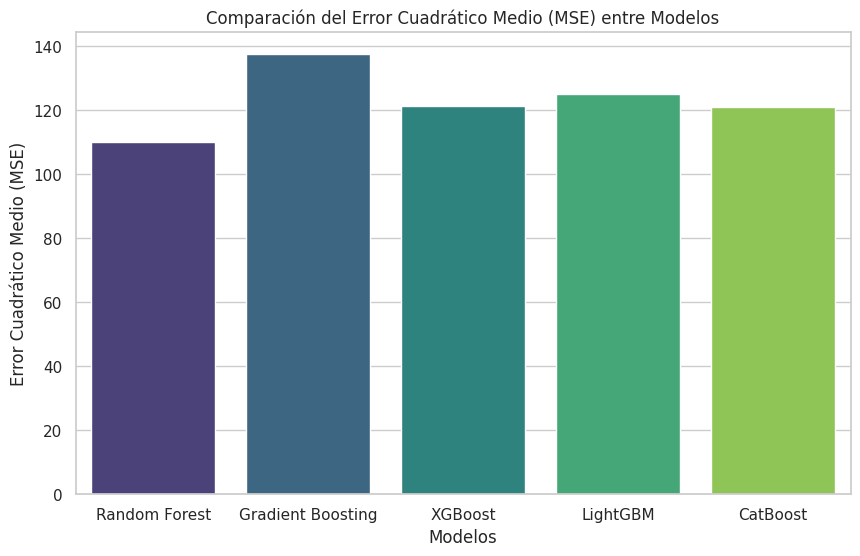

<ipython-input-8-b8c569f05e1e>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df, palette="viridis")


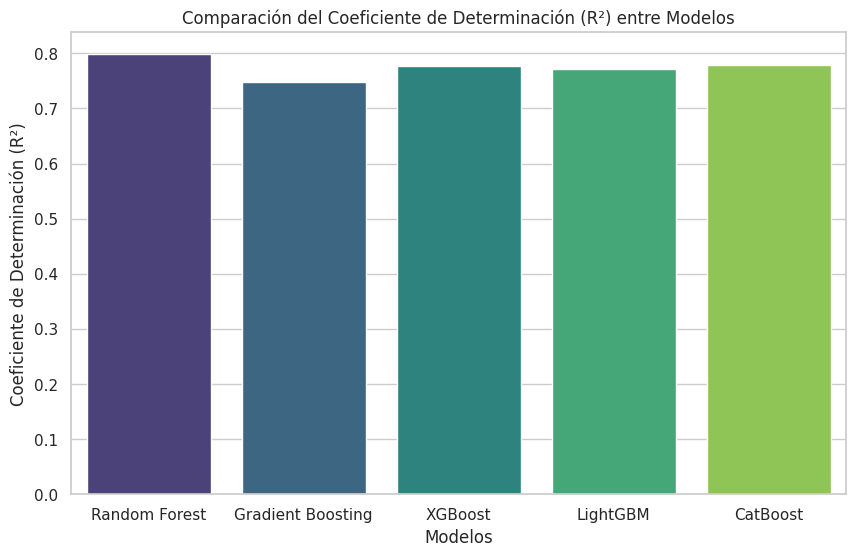

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost'],
    'MSE': [110.072769, 137.439762, 121.262084, 125.048707, 120.888201],
    'R2': [0.798224, 0.748057, 0.777712, 0.770771, 0.778398]
})

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear un gráfico de barras para MSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MSE', data=results_df, palette="viridis")
plt.title('Comparación del Error Cuadrático Medio (MSE) entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.show()

# Crear un gráfico de barras para R2
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=results_df, palette="viridis")
plt.title('Comparación del Coeficiente de Determinación (R²) entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('Coeficiente de Determinación (R²)')
plt.show()


Los resultados obtenidos en este entrenamiento presentan que el modelo **Random Forest** es que obtiene un menor error y una mayor R2.

El modelo con los peores resultados es **Gradient Boosting**, mientras que el resto presentan resultados muy similares.

#Entregable 4

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


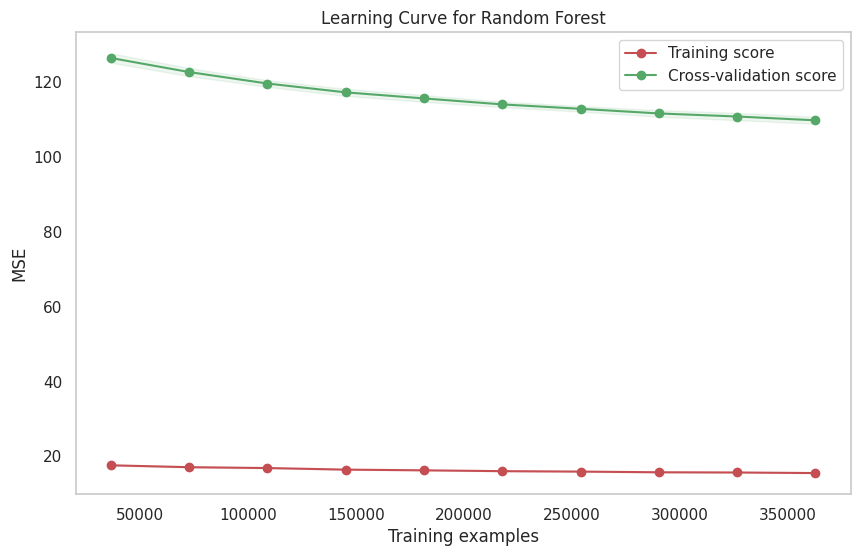

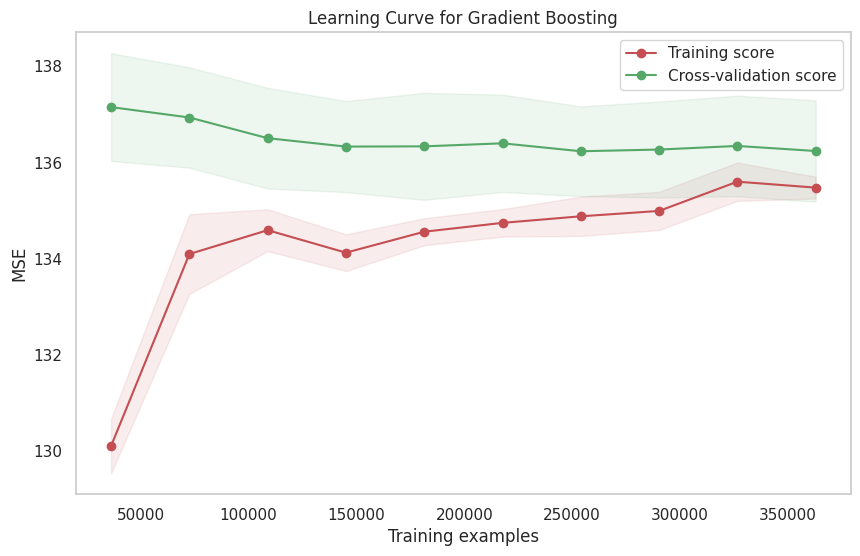

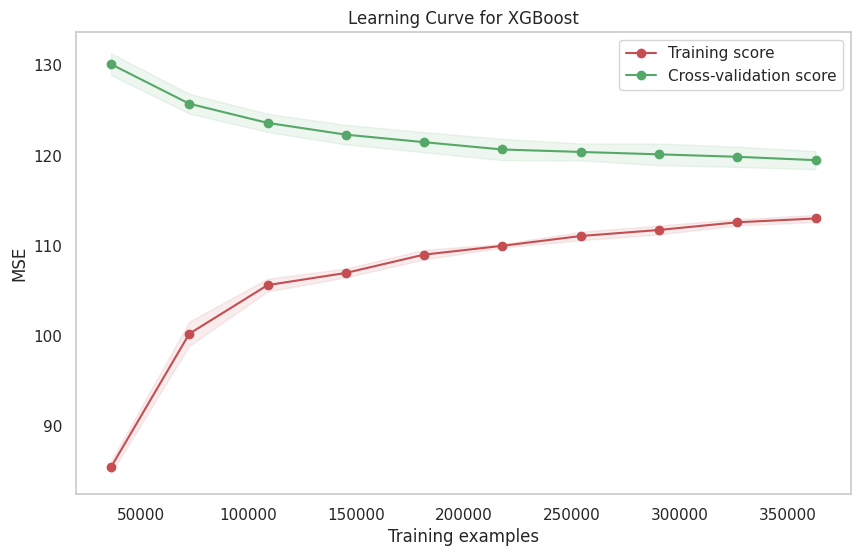

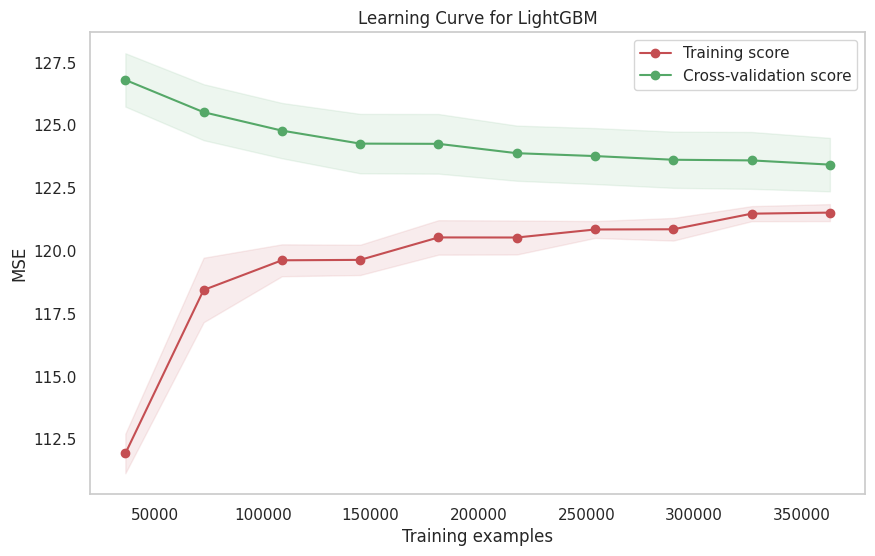

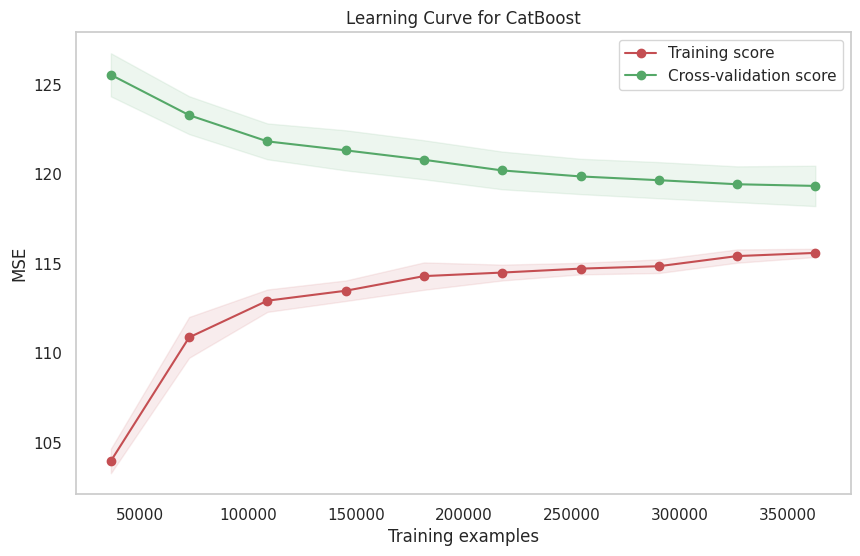

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Definir una función para trazar las curvas de aprendizaje
def plot_learning_curve(model, X, y, model_name, cv=5):
    plt.figure(figsize=(10, 6))
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='neg_mean_squared_error',
                                                            n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training examples')
    plt.ylabel('MSE')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Lista de modelos
models = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
]

# Generar curvas de aprendizaje para cada modelo
for name, model in models:
    plot_learning_curve(model, X_train, y_train, name)


En la gráfica de Ramdom Forest se puede observar cómo el modelo se encuentra Underfitting, se puede ver que por más muestras que tenga el modelo se ve muy lejana la convergencia de la curva de entrenamiento y validación cruzada.

El resto de los modelos presentan curvas muy alejadas en las primeras muestras, pero conforme aumenta el número tienden a juntarse y es muy probable que converjan en algún momento.

A continuación ejecutaremos una hiperparametrización de los modelos Xgboost y Catboost los cuales mostraron buen desempeño de acuerdo con los resultados anteriores.

##Hiperparametrización

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Dividir los datos en conjuntos de entrenamiento y prueba
X = geo_regist.drop(columns=['DT'])
y = geo_regist['DT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir los hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
print(f"Mejores hiperparámetros para XGBoost: {grid_search.best_params_}")

# Evaluar el modelo con los mejores parámetros
best_xg_reg = grid_search.best_estimator_
y_pred = best_xg_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost MSE: {mse}")
print(f"XGBoost R2: {r2}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros para XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
XGBoost MSE: 114.69055159620156
XGBoost R2: 0.7897587486327003


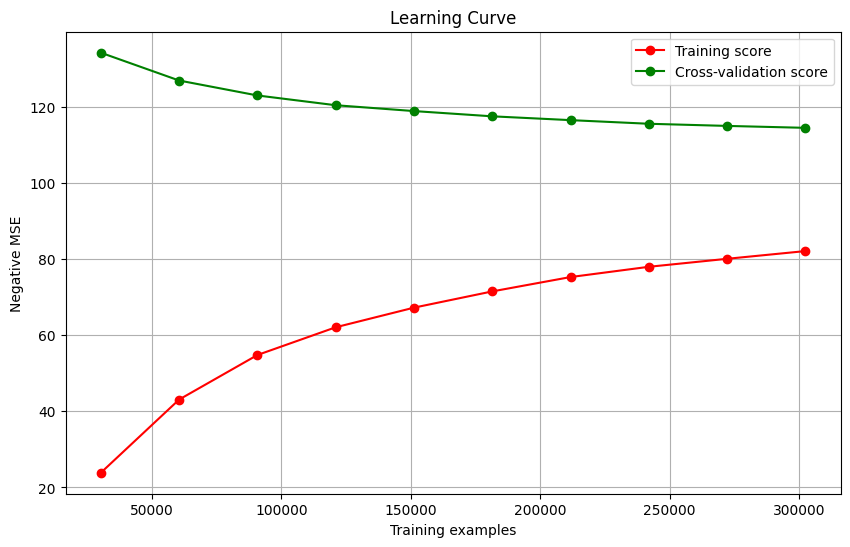

XGBoost MSE: 114.69055159620156
XGBoost R2: 0.7897587486327003


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Hiperparámetros
best_params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
mse = 114.69055159620156
r2 = 0.7897587486327003

# Dividir los datos en conjuntos de entrenamiento y prueba (reemplaza con tus propios datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo con los mejores parámetros encontrados
best_xg_reg = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Crear la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_xg_reg,
    X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Negative MSE")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Imprimir métricas del modelo en el conjunto de prueba
print(f"XGBoost MSE: {mse}")
print(f"XGBoost R2: {r2}")


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Definir el modelo
cb_reg = CatBoostRegressor(random_seed=42, verbose=0)

# Definir los hiperparámetros a probar
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 1, 2]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=cb_reg, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
print(f"Mejores hiperparámetros para CatBoost: {grid_search.best_params_}")

# Evaluar el modelo con los mejores parámetros
best_cb_reg = grid_search.best_estimator_
y_pred = best_cb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"CatBoost MSE: {mse}")
print(f"CatBoost R2: {r2}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mejores hiperparámetros para CatBoost: {'bagging_temperature': 0, 'depth': 10, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.2}
CatBoost MSE: 118.08666734660456
CatBoost R2: 0.7835332695917872


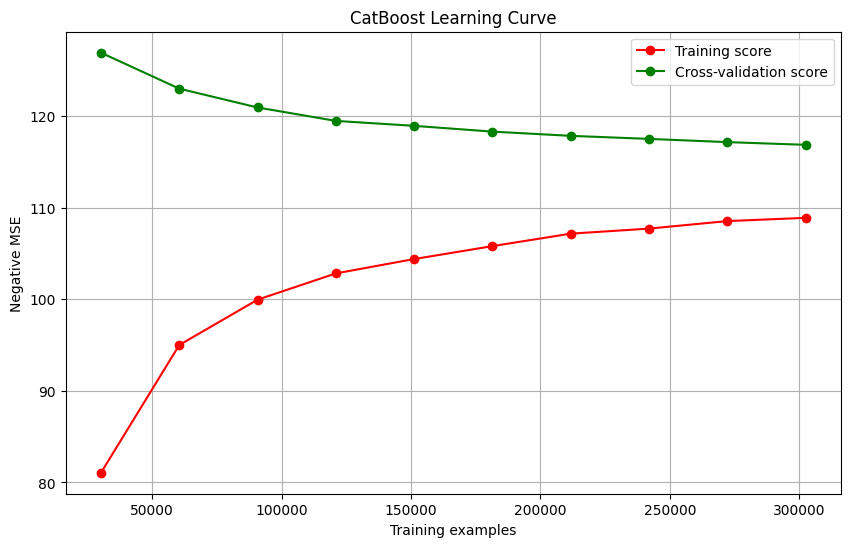

CatBoost MSE: 118.08666734660456
CatBoost R2: 0.7835332695917872


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

# Hiperparámetros
best_params_catboost = {'bagging_temperature': 0, 'depth': 10, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.2}
mse_catboost = 118.08666734660456
r2_catboost = 0.7835332695917872

# Dividir los datos en conjuntos de entrenamiento y prueba (reemplaza con tus propios datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo CatBoost con los mejores parámetros encontrados
best_catboost = CatBoostRegressor(**best_params_catboost, random_state=42, verbose=False)

# Crear la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_catboost,
    X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Negative MSE")
plt.title("CatBoost Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Imprimir métricas del modelo en el conjunto de prueba
print(f"CatBoost MSE: {mse_catboost}")
print(f"CatBoost R2: {r2_catboost}")


Después de obtener los hiperparámetros en ambos modelos Xgboost y CatBoost, se observa en las gráficas de aprendizaje que no tuvo una gran mejoría con respcto a la primera corrida.

#Entregable 5

**Ensamble homogeneo**

En los modelos realizados en la sección anterior se obtuvieron los mejores métricas con el modelo **Xgboost**, a continuación se ejecutará un ensamble homogeneo a partir del modelo individual mencionado.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging XGBoost MSE: 114.06715701242149
Bagging XGBoost R2: 0.7909015041218445


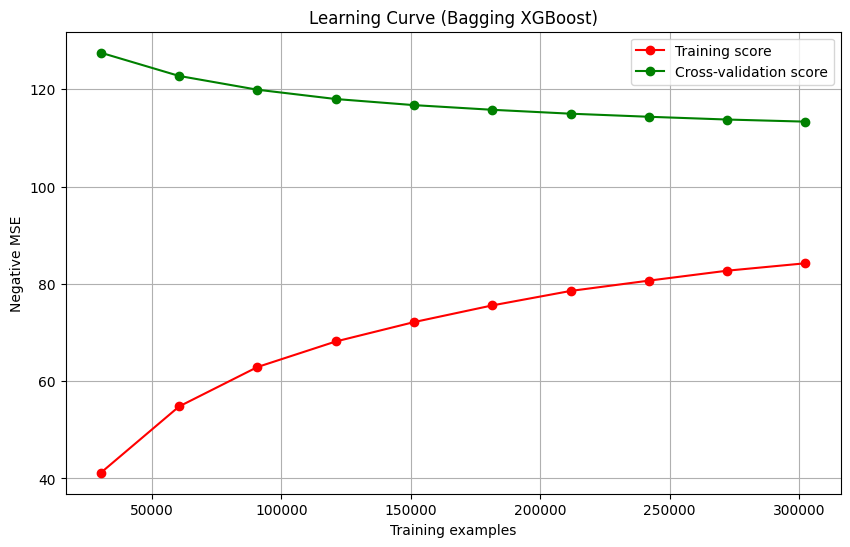

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Hiperparámetros
best_params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}

# Dividir los datos en conjuntos de entrenamiento y prueba (reemplaza con tus propios datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo base con los mejores parámetros encontrados
base_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Crear el ensamble usando Bagging
bagging_model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=42, n_jobs=-1)

# Entrenar el ensamble
bagging_model.fit(X_train, y_train)

# Predecir
y_pred = bagging_model.predict(X_test)

# Evaluar el ensamble
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Bagging XGBoost MSE: {mse}")
print(f"Bagging XGBoost R2: {r2}")

# Crear la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=bagging_model,
    X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Negative MSE")
plt.title("Learning Curve (Bagging XGBoost)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging CatBoost MSE: 117.725631132038
Bagging CatBoost R2: 0.7841950913764328


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


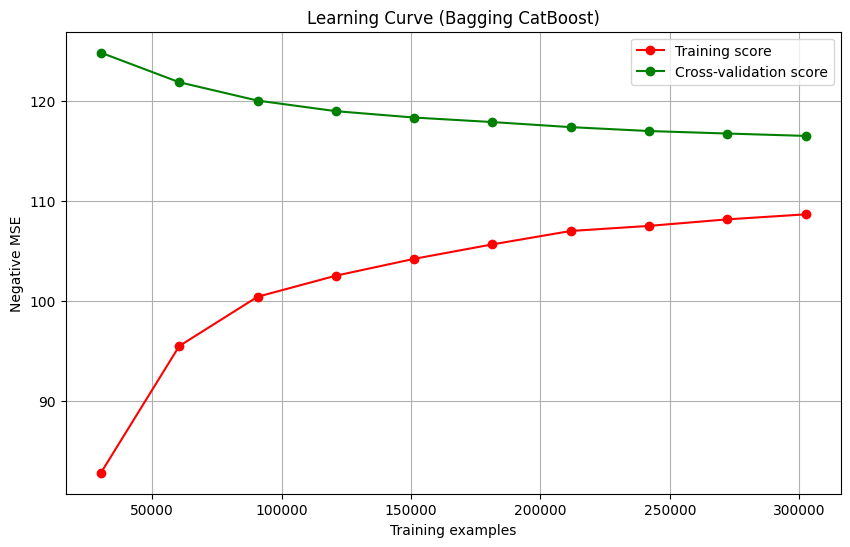

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

# Hiperparámetros
best_params_catboost = {'bagging_temperature': 0, 'depth': 10, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.2}
mse_catboost = 118.08666734660456
r2_catboost = 0.7835332695917872

# Dividir los datos en conjuntos de entrenamiento y prueba (reemplaza con tus propios datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo base con los mejores parámetros encontrados para CatBoost
base_model_catboost = CatBoostRegressor(**best_params_catboost, random_state=42, verbose=False)

# Crear el ensamble usando Bagging
bagging_model_catboost = BaggingRegressor(base_estimator=base_model_catboost, n_estimators=10, random_state=42, n_jobs=-1)

# Entrenar el ensamble
bagging_model_catboost.fit(X_train, y_train)

# Predecir
y_pred_catboost = bagging_model_catboost.predict(X_test)

# Evaluar el ensamble
mse_bagging_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_bagging_catboost = r2_score(y_test, y_pred_catboost)

print(f"Bagging CatBoost MSE: {mse_bagging_catboost}")
print(f"Bagging CatBoost R2: {r2_bagging_catboost}")

# Crear la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=bagging_model_catboost,
    X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Negative MSE")
plt.title("Learning Curve (Bagging CatBoost)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

**Ensamble heterogeneo**

De la misma manera se realizará un ensamble heterogeneo a partir del mismo modelo base.

Stacking MSE: 114.47052349649464
Stacking R2: 0.7901620859815451


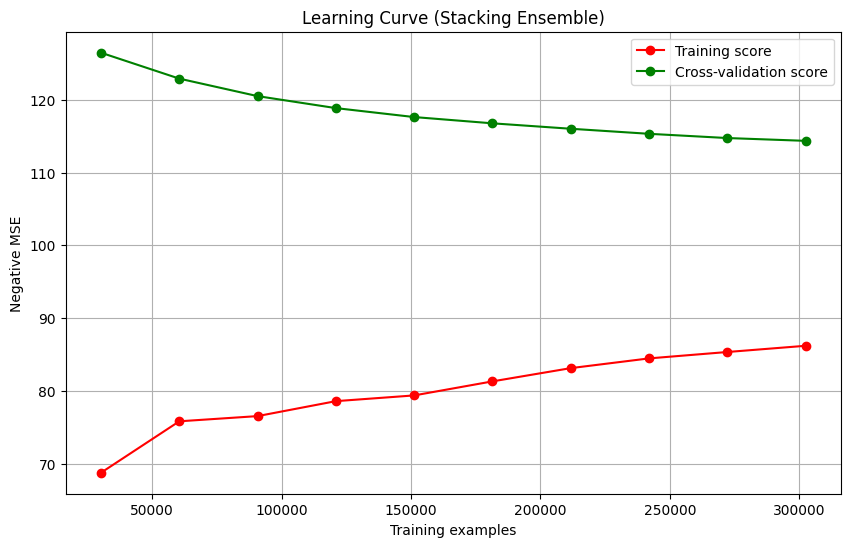

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import xgboost as xgb

# Hiperparámetros
best_params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}

# Definir los modelos base
estimators = [
    #('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    #g('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', **best_params)),
    #('lgb', LGBMRegressor(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(n_estimators=100, random_state=42, verbose=0))
]

# Definir el modelo meta
meta_model = Ridge()

# Crear el modelo de stacking
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model, n_jobs=-1)

# Entrenar el ensamble
stacking_model.fit(X_train, y_train)

# Predecir
y_pred = stacking_model.predict(X_test)

# Evaluar el ensamble
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Stacking MSE: {mse}")
print(f"Stacking R2: {r2}")

# Crear la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=stacking_model,
    X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Negative MSE")
plt.title("Learning Curve (Stacking Ensemble)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import xgboost as xgb

# Hiperparámetros
best_params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}

# Definir los modelos base
estimators = [
    #('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', **best_params)),
    #('lgb', LGBMRegressor(n_estimators=100, random_state=42)),
    #('cat', CatBoostRegressor(n_estimators=100, random_state=42, verbose=0))
]

# Definir el modelo meta
meta_model = Ridge()

# Crear el modelo de stacking
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model, n_jobs=-1)

# Entrenar el ensamble
stacking_model.fit(X_train, y_train)

# Predecir
y_pred = stacking_model.predict(X_test)

# Evaluar el ensamble
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Stacking MSE: {mse}")
print(f"Stacking R2: {r2}")

# Crear la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=stacking_model,
    X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Negative MSE")
plt.title("Learning Curve (Stacking Ensemble)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Stacking MSE: 114.46009897619304
Stacking R2: 0.7901811953516075


#Modelo Final

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging CatBoost MSE: 117.725631132038
Bagging CatBoost R2: 0.7841950913764328
Bagging CatBoost MAE: 6.774039195352502
Bagging CatBoost MedAE: 4.342583210070398
Bagging CatBoost Explained Variance Score: 0.7841972523561559


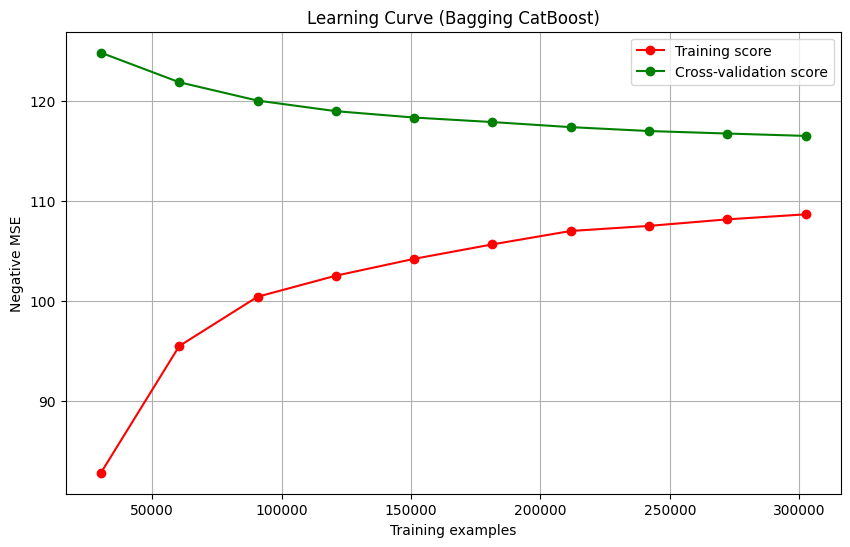

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
from catboost import CatBoostRegressor

# Hiperparámetros
best_params_catboost = {'bagging_temperature': 0, 'depth': 10, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.2}
mse_catboost = 118.08666734660456
r2_catboost = 0.7835332695917872

# Dividir los datos en conjuntos de entrenamiento y prueba (reemplaza con tus propios datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo base con los mejores parámetros encontrados para CatBoost
base_model_catboost = CatBoostRegressor(**best_params_catboost, random_state=42, verbose=False)

# Crear el ensamble usando Bagging
bagging_model_catboost = BaggingRegressor(base_estimator=base_model_catboost, n_estimators=10, random_state=42, n_jobs=-1)

# Entrenar el ensamble
bagging_model_catboost.fit(X_train, y_train)

# Predecir
y_pred_catboost = bagging_model_catboost.predict(X_test)

# Evaluar el ensamble usando diferentes métricas
mse_bagging_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_bagging_catboost = r2_score(y_test, y_pred_catboost)
mae_bagging_catboost = mean_absolute_error(y_test, y_pred_catboost)
medae_bagging_catboost = median_absolute_error(y_test, y_pred_catboost)
evs_bagging_catboost = explained_variance_score(y_test, y_pred_catboost)

print(f"Bagging CatBoost MSE: {mse_bagging_catboost}")
print(f"Bagging CatBoost R2: {r2_bagging_catboost}")
print(f"Bagging CatBoost MAE: {mae_bagging_catboost}")
print(f"Bagging CatBoost MedAE: {medae_bagging_catboost}")
print(f"Bagging CatBoost Explained Variance Score: {evs_bagging_catboost}")

# Crear la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=bagging_model_catboost,
    X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Negative MSE")
plt.title("Learning Curve (Bagging CatBoost)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


#Conclusiones Clave
Se logró obtener un buen set de datos después de todos los procesos de limpieza y filtrado aplicados, el número de registros es adecuado para la generación de un modelo.

Para resolver el problema en este proyecto fue importante considerar modelos que sean robustos y efectivos para problemas de regresión en datasets grandes.

Después de evaluar diferentes modelos el que obtuvo el mejor desempeño fue el ensamble homogéneo del modelo Catboost, obteniendo las siguientes métricas:

•	Bagging CatBoost MSE: 117.725631132038

•	Bagging CatBoost R2: 0.7841950913764328

•	Bagging CatBoost MAE: 6.774039195352502

•	Bagging CatBoost MedAE: 4.342583210070398

•	Bagging CatBoost Explained Variance Score: 0.7841972523561559

MSE y MAE sugieren que los errores de las predicciones son relativamente bajos. R2 y Explained Variance Score indican que el modelo explica una gran parte de la variabilidad en los datos (78.4%). MedAE muestra que la mitad de las predicciones tienen errores absolutos menores a 4.34 unidades, lo que sugiere que el modelo es bastante preciso en la mayoría de los casos.

Al tratar de solucionar esta problemática mediante este enfoque se encontró que utilizar estos modelos, sugiere que es posible optimizar la operación de perforación de pozos y tener más información disponible, con un grado de precisión lo suficientemente aceptable para considerarlo como una herramienta de apoyo.

En la industria petrolera existen muy pocas soluciones que aborden estas problemáticas apalancándose de Inteligencia Artificial por lo que estas soluciones, podrían cerrar la brecha que aún es evidente entre las soluciones de ML e IA en esta industria.

